Dumping pendulum

$\phi''+ \frac{b}{m} \phi' + \omega^2 \sin\phi = 0$

$
\left(\begin{array}{c} 
x_1'\\
x_2'
\end{array}\right)
= 
\left(\begin{array}{c}
0 & 1 \\
0 & -\frac{b}{m}
\end{array}\right)
\left(\begin{array}{c} 
x_1\\
x_2
\end{array}\right)
+
\left(\begin{array}{c}
0 & 0 \\
-\omega & 0
\end{array}\right)
\left(\begin{array}{c} 
\sin x_1\\
\sin x_2
\end{array}\right)
$

$X' = AX + W \sigma(X)$

Identifier

$\hat{X'} = \hat{A}\hat{X} + \hat{W} \sigma_{1}(\hat{X})$

$\frac{d}{dt}(\hat{W}) = - K^{-1}P\Delta \sigma_{1}^T(\hat{x})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import linalg

In [2]:
import imageio
import os

In [3]:
from PIL import Image

In [4]:
#Activation function
def sigma(x, a=1, b=0):
    return a*np.sin(x+b)

In [5]:
#Sigmoidal activation function
def sigma_1(x, a=1, b=1):
    return a/(b-np.exp(-x))

In [6]:
#Pendulum approximation
def f(a, x, w, sig):
    return a@x + w@sig(x)

In [7]:
#Identifier design
def F(A,X,W,sig):
    return A@X + W@sig(X)

In [8]:
#Learning law
def dW(X,K,P,er,sig):
    
    k = linalg.inv(K)
    
    return -k@P@er@(sig(X).T)

In [9]:
#Solution of Algebraic Riccati Equation 
def ARE(A, R, Q):
    #P A + A.t P + P R P + Q = 0             <-- our system
    #P A + A.t P - P B R^{-1} B.t P + Q = 0  <-- python function
    
    p = linalg.solve_continuous_are(a=A, b=np.eye(*A.shape), q=Q, r=-np.linalg.inv(R))
    
    return p

In [10]:
#Identifier train loop
def identifier(f, F, dW, sig_1, sig_2, sig_3, T, n, a, A, w, x_0, K, L_1, L_2, L_sig,):
    t = np.linspace(0, T, n)
    x = np.array([x_0])
    X = np.array([x_0])
    er = np.array([x[0]-X[0]])
    W = np.array([w+0.3])
    h = T/n
    
    R = w@L_1@(w.T) + L_2
    l, _ = np.linalg.eig(linalg.inv(L_1))
    Q = l.max()*L_sig*np.eye(*w.shape)
    P = ARE(A, R, Q)
    
    for i in tqdm(range(n-1)):
        x = np.append(x, [x[i] + h*f(a, x[i], w, sig_1)], axis=0)
        X = np.append(X, [X[i] + h*F(A, X[i], W[i], sig_2)], axis=0)
        W = np.append(W, [W[i] + h*dW(X[i], K, P, er[i], sig_3)], axis=0)
        er = np.append(er, [x[i] - X[i]], axis=0)
        
    return t, er, x, X, W

In [11]:
def printres(res):
    err = [(abs(e)).sum() for e in res[1]]
    
    plt.plot(res[0], err, 'r')
    plt.title('Error')
    plt.show()
    
    
    fig, ax = plt.subplots(2,2)
    fig.suptitle('Trajectories')
    
    ax[0,0].plot(res[0][:], res[2][:,0,:])
    ax[0,0].set_title('phi_1')
    
    ax[0,1].plot(res[0][:], res[3][:,0,:])
    ax[0,1].set_title('Phi_1')
    
    ax[1,0].plot(res[0], res[2][:,1,:])
    ax[1,0].set_title('x_1')
    
    ax[1,1].plot(res[0], res[3][:,1,:])
    ax[1,1].set_title('X_1')
    
    f, a = plt.subplots(2)
    f.suptitle('Phase planes')
    
    a[0].plot(res[2][:,0,:], res[2][:,1,:])
    a[0].set_title('pendulum')
    
    a[1].plot(res[3][:,0,:], res[3][:,1,:])
    a[1].set_title('identifier')
    

In [12]:
def make_gif(res):
    fnames = []

    for i in tqdm(range(0,len(res[3]), 30)):
        fname = f'{i}.png'
        fnames.append(fname)

        plt.plot(np.sin(res[3][:,0,:]), -np.cos(res[3][:,0,:]), color='gray')
        plt.plot(np.sin(res[2][i,0,:]), -np.cos(res[2][i,0,:]), color='blue', marker='o', label='pendulum')
        plt.plot(np.sin(res[3][i,0,:]), -np.cos(res[3][i,0,:]), color='red', marker='o', label='identifier')
        plt.legend()
        plt.savefig(fname)
        plt.close()

    with imageio.get_writer('mygif.gif', mode='I') as writer:
        for fname in fnames:
            img = imageio.imread(fname)
            writer.append_data(img)

    for file in fnames:
        os.remove(file)

100%|████████████████████████████████████████████████████████████████████████████| 8999/8999 [00:07<00:00, 1135.72it/s]


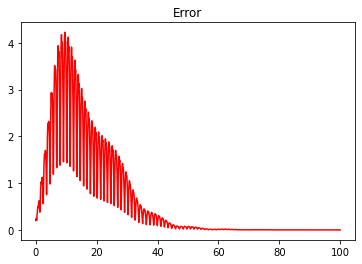

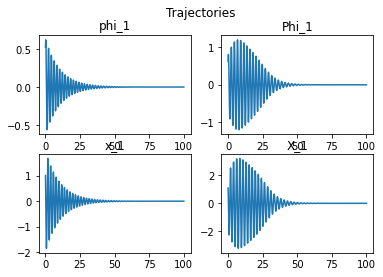

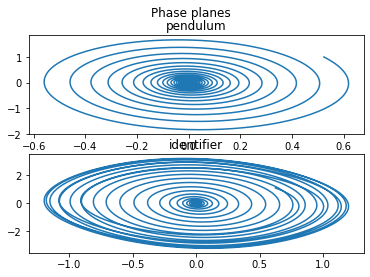

In [10]:
aa = np.array([[0, 1],
               [0, -0.3]])

AA = np.array([[0.0061, 1],
               [0.8, -0.3]])

ww = np.array([[0, 0],
               [-10, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 100*np.array([[0.8, 2],
                   [2, 0.3]])

LL_1 = np.array([[8.7, 0.53],
                 [0.53, 8.0]])

LL_2 = np.array([[0.5, 0.0],
                 [0.0, 0.5]])
LL_sig = 1.5


res = identifier(f, F, dW, sigma, T=100, n=9000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

100%|██████████████████████████████████████████████████████████████████████████| 14999/14999 [00:03<00:00, 3773.89it/s]


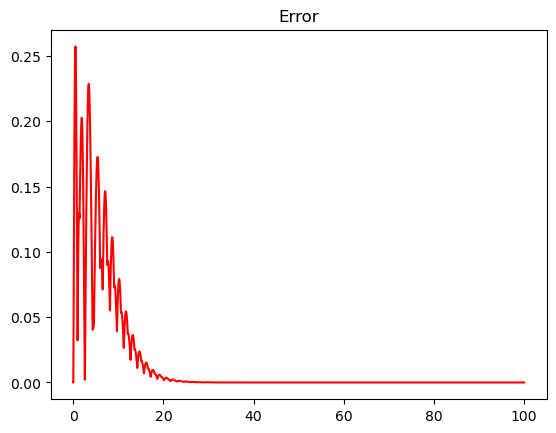

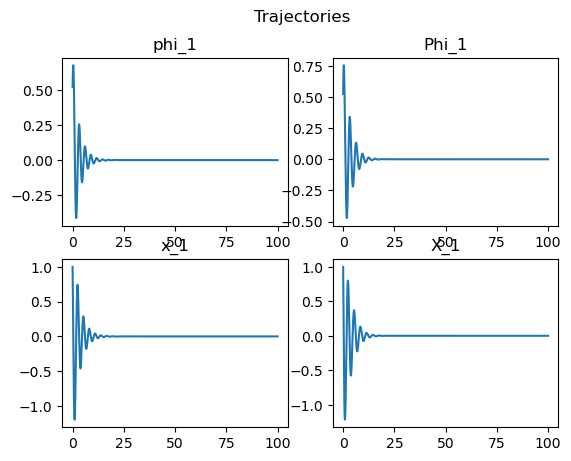

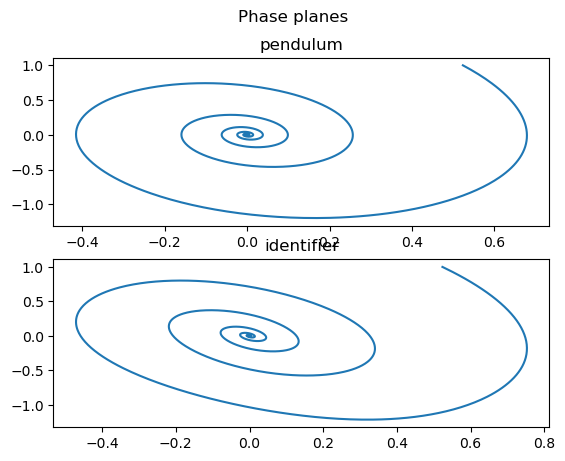

In [45]:
#identifier: sin, learning law: sin
aa = np.array([[0, 1],
               [0, -0.7]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                  


res = identifier(f, F, dW, sigma, sigma, sigma, T=100, n=15000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

In [42]:
def play(f, F, sig_1, sig_2, sig_3, T, n, a, A, w, W, x_0, K, L_1, L_2, L_sig,):
    t = np.linspace(0, T, n)
    x = np.array([x_0])
    X = np.array([x_0])
    er = np.array([x[0]-X[0]])
    h = T/n
    
    for i in tqdm(range(n-1)):
        x = np.append(x, [x[i] + h*f(a, x[i], w, sig_1)], axis=0)
        X = np.append(X, [X[i] + h*F(A, X[i], W, sig_2)], axis=0)
        er = np.append(er, [x[i] - X[i]], axis=0)
        
    return t, er, x, X

100%|██████████████████████████████████████████████████████████████████████████| 14999/14999 [00:02<00:00, 7309.71it/s]


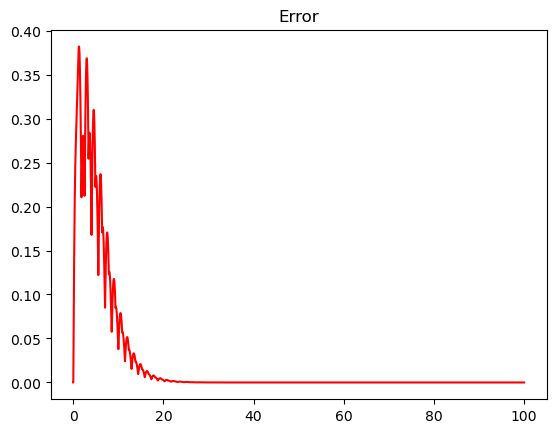

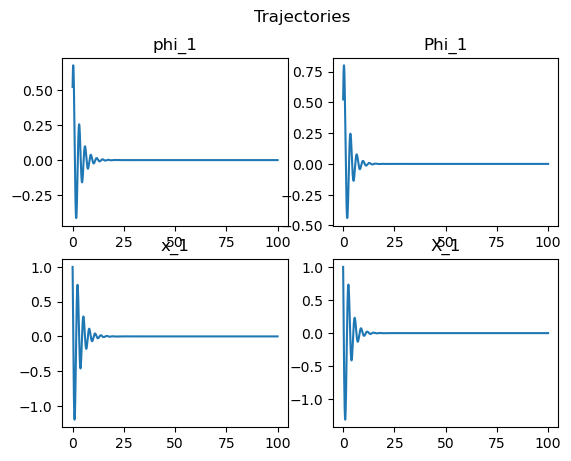

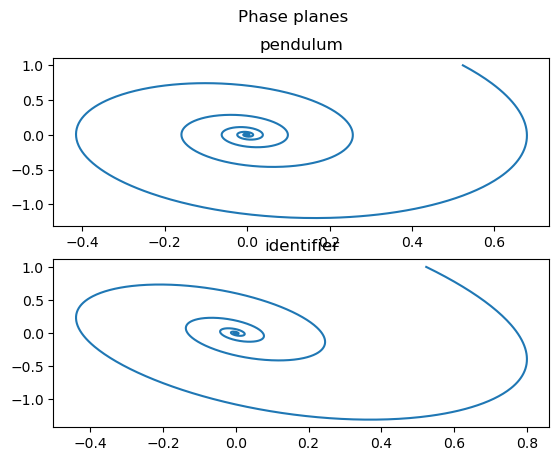

In [46]:
new_w = res[-1][-1]
pl = play(f, F, sigma, sigma, sigma, T=100, n=15000, a=aa, A=AA, w=ww, W=new_w, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(pl)

In [47]:
make_gif(pl)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:25<00:00,  3.43it/s]
C:\Users\Egor\AppData\Local\Temp\ipykernel_9860\2993933478.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fname)


100%|█████████████████████████████████████████████████████████████████████████| 14999/14999 [00:01<00:00, 11146.10it/s]


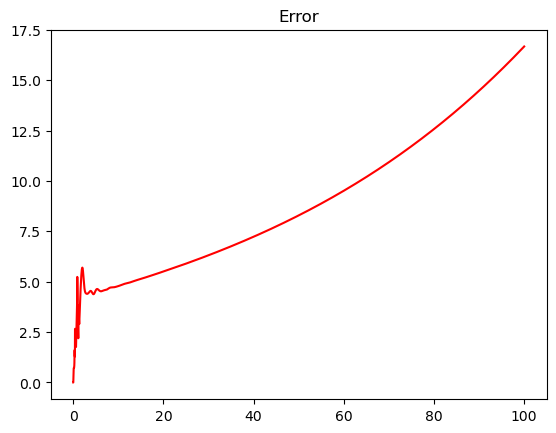

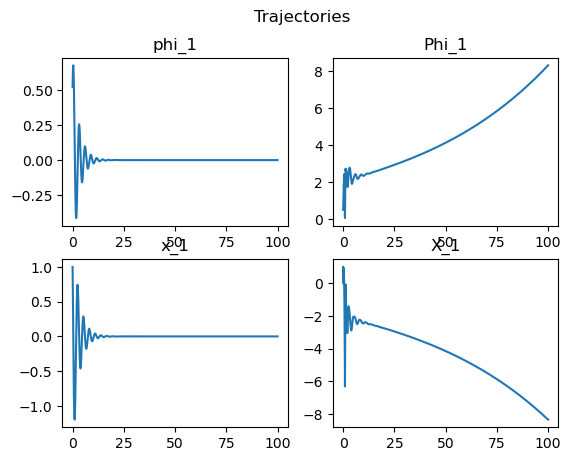

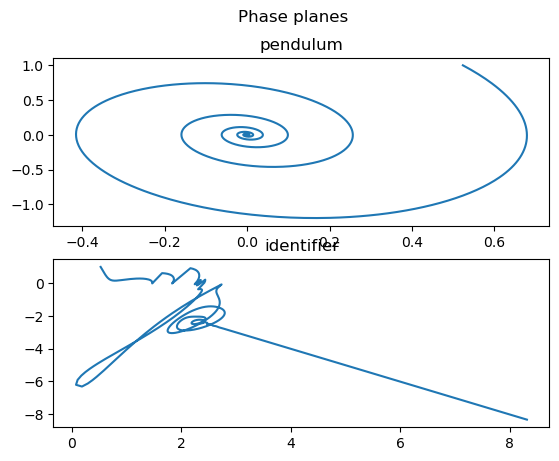

In [35]:
#idetetifier: sigmoidal, learning law: sigmoidal

aa = np.array([[0, 1],
               [0, -0.7]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma_1, sigma_1, T=100, n=15000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

100%|█████████████████████████████████████████████████████████████████████████| 10999/10999 [00:00<00:00, 16481.30it/s]


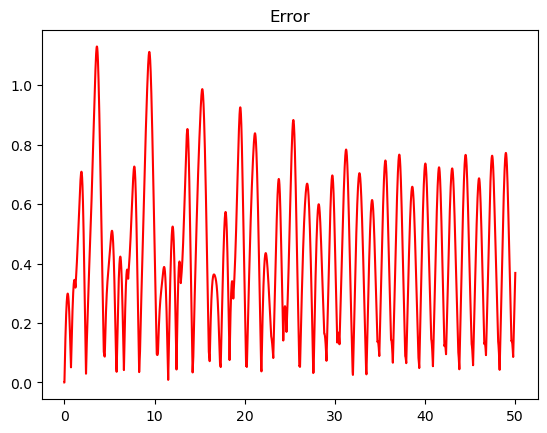

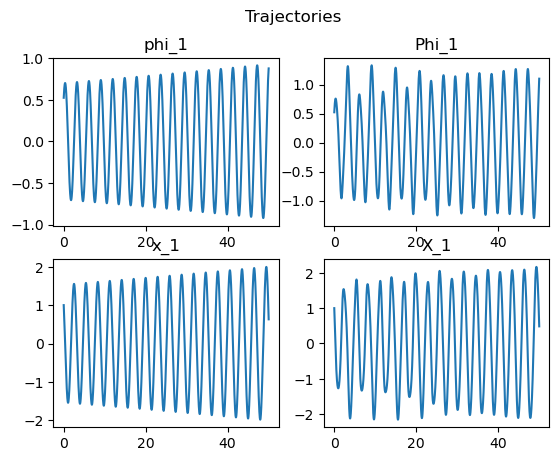

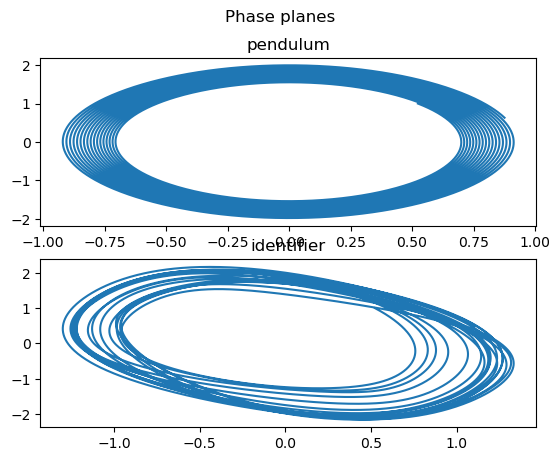

In [16]:
#pendulum without dumping
aa = np.array([[0, 1],
               [0, -0.01]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!



res = identifier(f, F, dW, sigma, sigma, sigma, T=50, n=11000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

100%|█████████████████████████████████████████████████████████████████████████| 14999/14999 [00:01<00:00, 13576.74it/s]


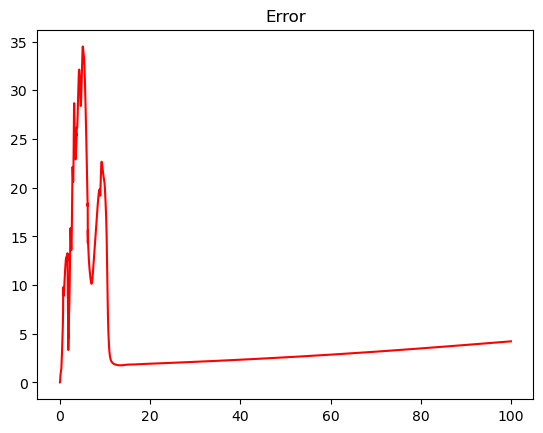

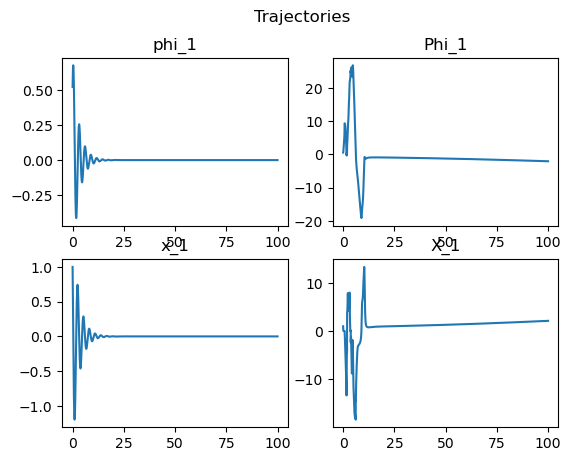

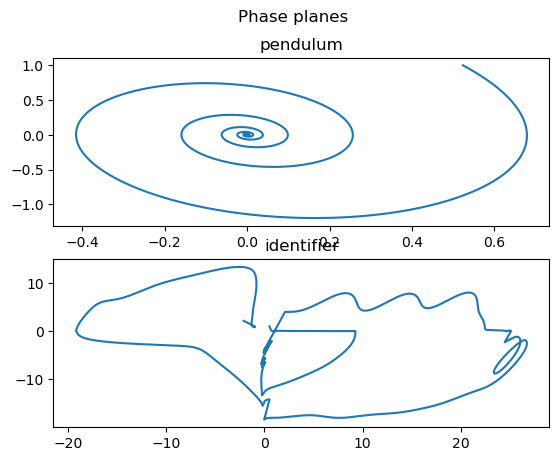

In [34]:
#identifier: sigmoidal, learning law: sin
aa = np.array([[0, 1],
               [0, -0.7]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma_1, sigma, T=100, n=15000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

100%|██████████████████████████████████████████████████████████████████████████| 29999/29999 [00:03<00:00, 8834.82it/s]


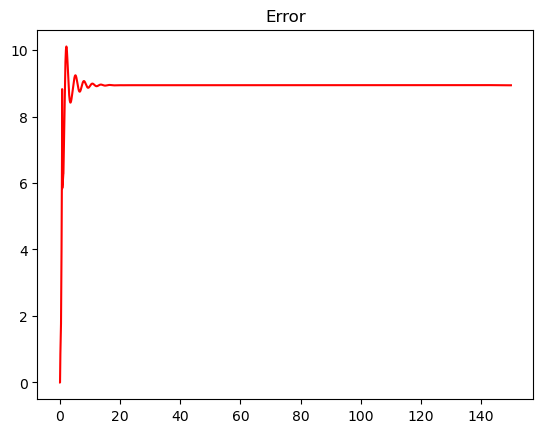

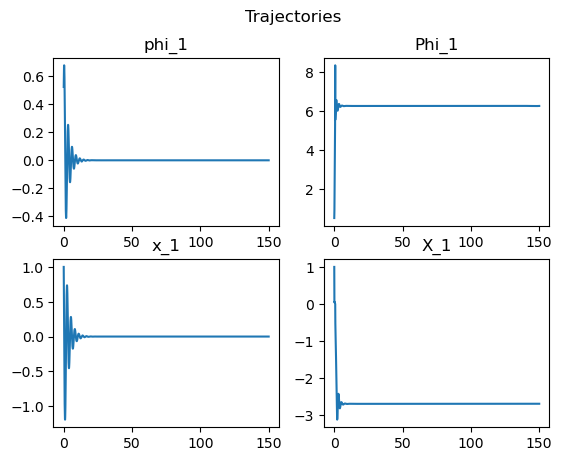

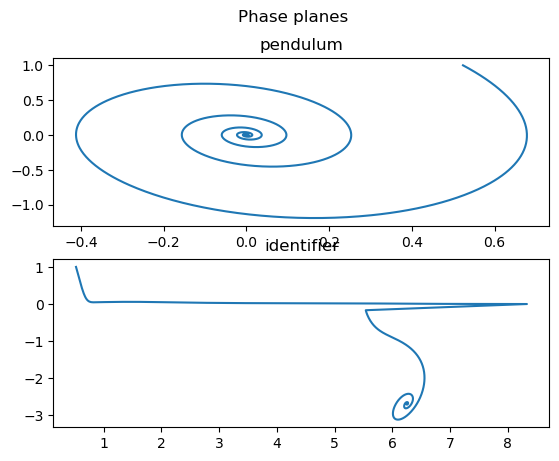

In [20]:
#idetetifier: sigmoidal, learning law: sin

aa = np.array([[0, 1],
               [0, -0.7]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma_1, sigma, T=150, n=30000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

 13%|█████████▎                                                                | 3770/29999 [00:00<00:01, 18929.35it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_11436\3218552173.py:3: RuntimeWarning: overflow encountered in exp
  return a/(b-np.exp(-x))
100%|██████████████████████████████████████████████████████████████████████████| 29999/29999 [00:04<00:00, 6515.24it/s]


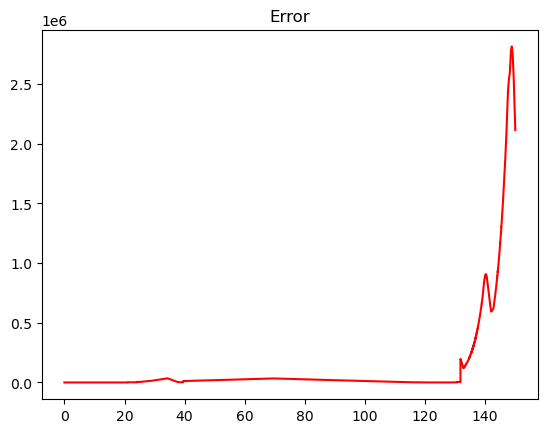

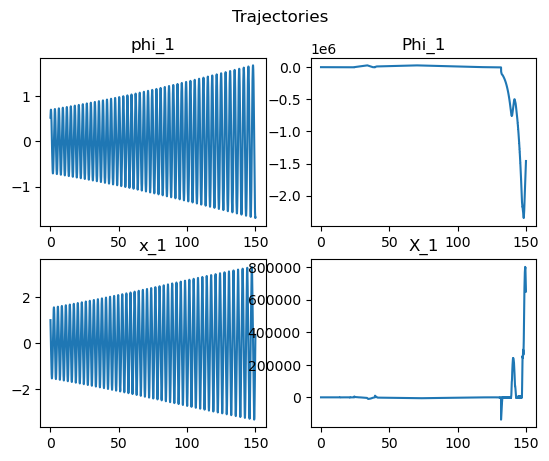

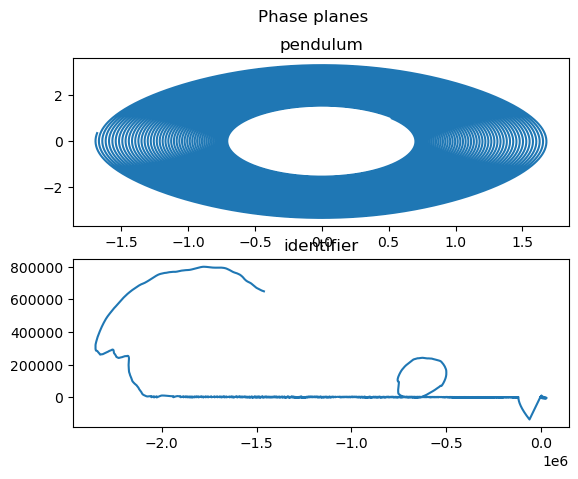

In [32]:
#identifier: sigmoidal, learning law: sin
aa = np.array([[0, 1],
               [0, -0.01]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma_1, sigma, T=150, n=30000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

 76%|████████████████████████████████████████████████████████▍                 | 45732/59999 [00:11<00:10, 1300.13it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_11436\3218552173.py:3: RuntimeWarning: overflow encountered in exp
  return a/(b-np.exp(-x))
100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:22<00:00, 2686.79it/s]


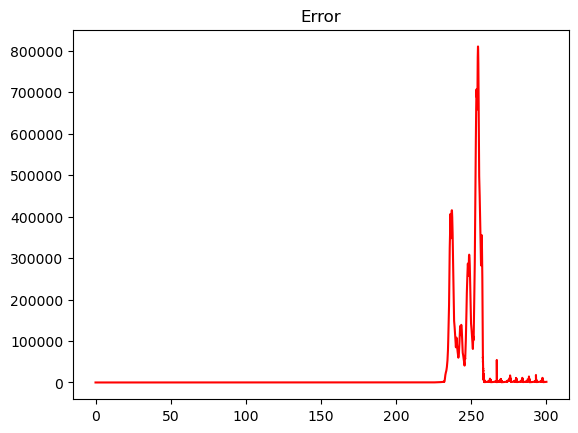

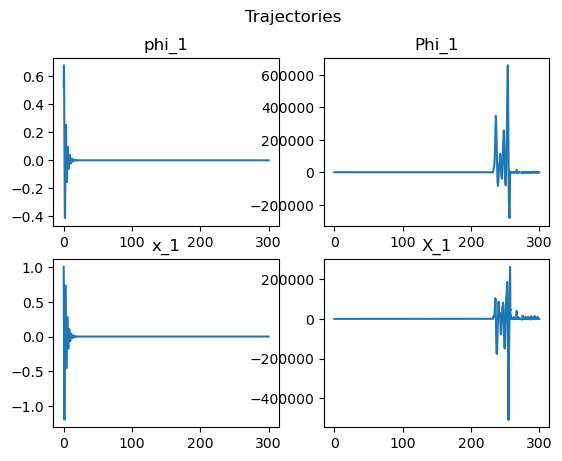

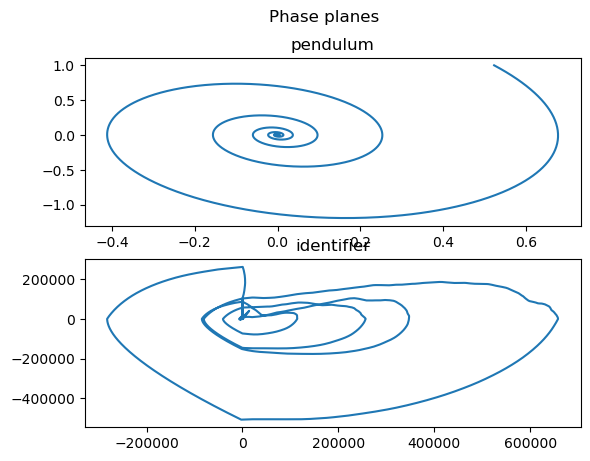

In [29]:
# idetetifier: sigmoidal, learning law: sin

aa = np.array([[0, 1],
               [0, -0.7]])  #!!

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     
LL_sig = 1.5                   


res = identifier(f, F, dW, sigma, sigma_1, sigma, T=300, n=60000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

100%|█████████████████████████████████████████████████████████████████████████| 19999/19999 [00:01<00:00, 11883.93it/s]


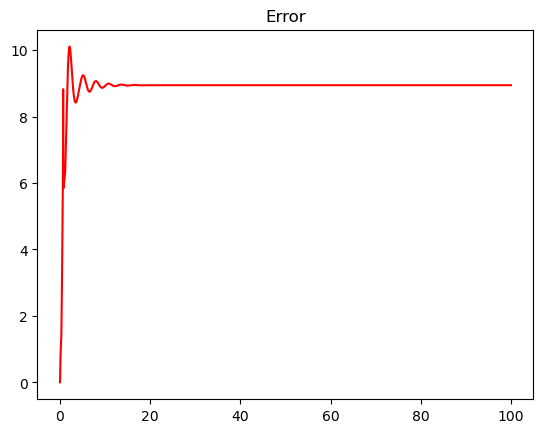

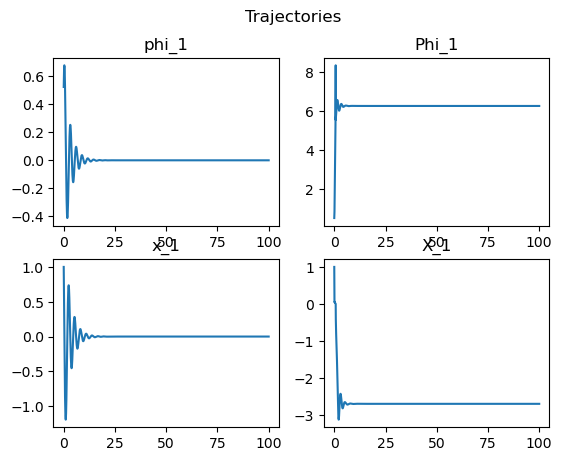

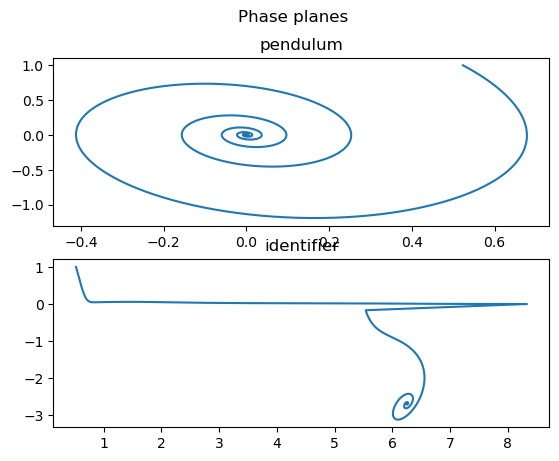

In [21]:
#idetetifier: sin, learning law: sigmoidal

aa = np.array([[0, 1],
               [0, -0.7]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma_1, sigma, T=100, n=20000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

Q: 
If identifier and learning law use periodic activation function then error diverges. 

If identifier has sigmoidal activation function and learning law has periodic then error tends to finite value. 

100%|█████████████████████████████████████████████████████████████████████████| 14999/14999 [00:01<00:00, 11702.67it/s]


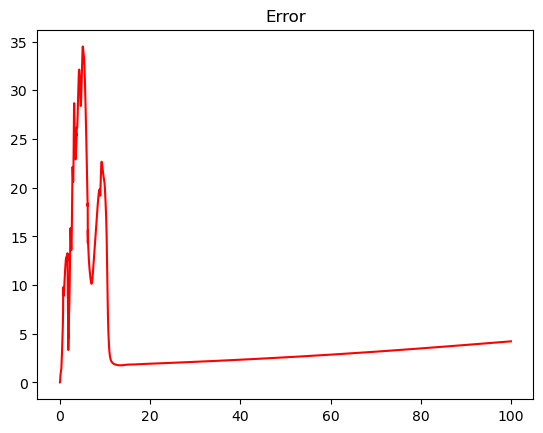

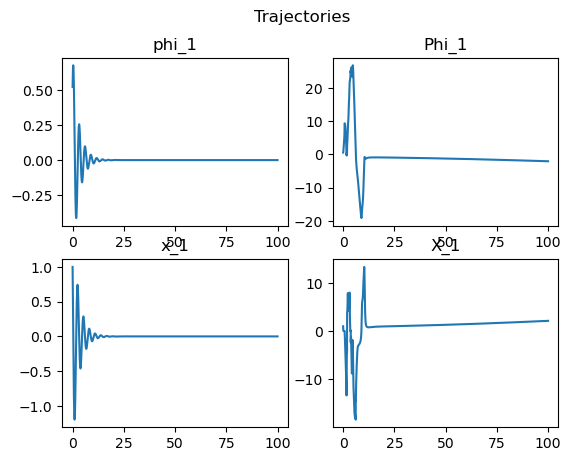

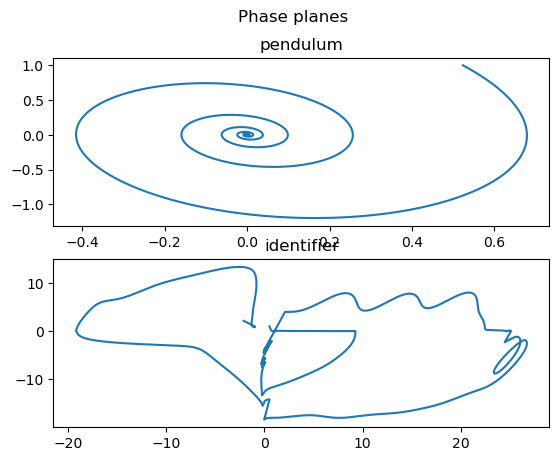

In [23]:
#idetetifier: sigmoidal , learning law: sin
aa = np.array([[0, 1],
               [0, -0.7]])

AA = np.array([[0.003, 1],
               [-0.67, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma_1, sigma, T=100, n=15000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 5744.20it/s]


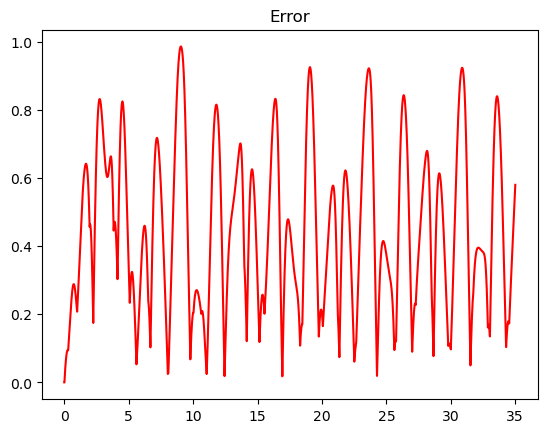

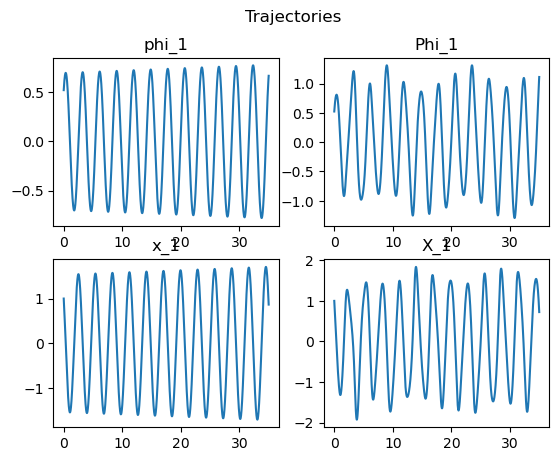

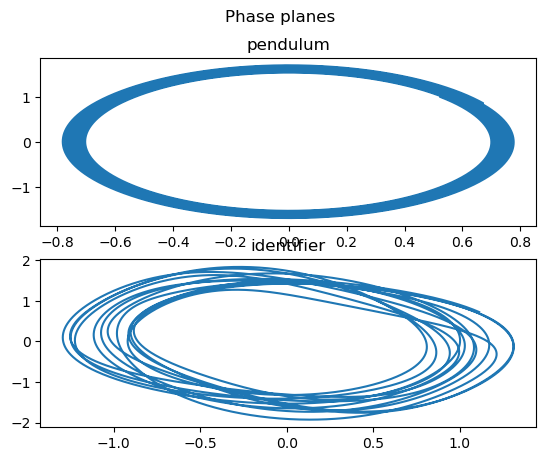

In [31]:

aa = np.array([[0, 1],
               [0, -0.01]])

AA = np.array([[0.003, 1],
               [0.8, -1.18]])  #!!!

ww = np.array([[0, 0],
               [-5, 0]])

xx_0 = np.array([[np.pi/6],
                 [1]])

KK = 2.9*np.array([[1.2, 0.002],
                   [0.002, 0.5]])

LL_1 = np.array([[33.01, 8.01],
                 [8.01, 33.05]])

LL_2 = np.array([[0.5, -0.0],
                 [-0.0, 0.5]])     #!!!
LL_sig = 1.5                   #!!!


res = identifier(f, F, dW, sigma, sigma, sigma, T=35, n=10000, a=aa, A=AA, w=ww, x_0=xx_0, K=KK, L_1=LL_1, L_2=LL_2, L_sig=LL_sig)
printres(res)

In [99]:
make_gif(res)

100%|████████████████████████████████████████████████████████████████████████████████| 334/334 [01:35<00:00,  3.50it/s]
C:\Users\Egor\AppData\Local\Temp\ipykernel_10976\2993933478.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fname)


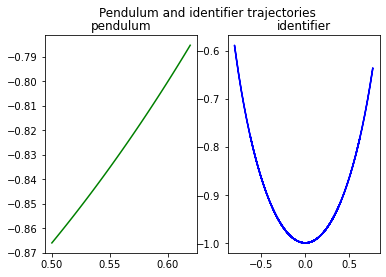

In [53]:
#Pendulum trajectories
fig, ax = plt.subplots(1,2)
fig.suptitle('Pendulum and identifier trajectories')

ax[0].plot(np.sin(res_1[2][:70,0,:]), -np.cos(res_1[2][:70,0,:]), 'g')
ax[0].set_title('pendulum')

ax[1].plot(np.sin(res_1[3][:,0,:]), -np.cos(res_1[3][:,0,:]), 'b')
ax[1].set_title('identifier')

for a in ax.flat:
    a.label_outer